In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [2]:
# Data ingest
data_url = "https://drive.google.com/uc?id=1_jYVXj7mt8Zzpjn8WGI111G-kWRTbfjU"
df = pd.read_csv(data_url,index_col='date',parse_dates=['date'])
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263520 entries, 2017-03-11 00:00:00 to 2017-09-09 23:59:00
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   plant.feed.iron.comp                        241920 non-null  float64
 1   plant.feed.silica.comp                      241920 non-null  float64
 2   plant.flotation.sump01.starch.flow          241920 non-null  float64
 3   plant.flotation.sump01.amina.flow           241920 non-null  float64
 4   plant.flotation.sump01.discharge.flow       241920 non-null  float64
 5   plant.flotation.sump01.discharge.ph         241920 non-null  float64
 6   plant.flotation.sump01.discharge.density    241920 non-null  float64
 7   plant.flotation.bank01.column01.air.flow    241920 non-null  float64
 8   plant.flotation.bank01.column02.air.flow    241920 non-null  float64
 9   plant.flotation.bank01.column03.air.

In [3]:
# Downsampling
df = df.resample('8h').median()
df = df.dropna()

In [4]:
# Data statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
plant.feed.iron.comp,504.0,56.275357,5.210363,42.740000,52.610000,56.020000,59.720000,65.780000
plant.feed.silica.comp,504.0,14.687897,6.887577,1.310000,8.870000,13.965000,19.975000,33.400000
plant.flotation.sump01.starch.flow,504.0,3050.092663,829.553960,291.376858,2387.680000,3192.957500,3589.408750,6118.155000
plant.flotation.sump01.amina.flow,504.0,494.606631,70.458004,244.994450,452.955875,509.040750,546.771750,678.816151
plant.flotation.sump01.discharge.flow,504.0,397.256468,8.407093,377.916000,399.556125,399.917500,400.242125,417.001976
plant.flotation.sump01.discharge.ph,504.0,9.770993,0.338706,8.754432,9.565766,9.801090,10.008213,10.723900
plant.flotation.sump01.discharge.density,504.0,1.687244,0.053702,1.519950,1.664439,1.700392,1.717650,1.784960
plant.flotation.bank01.column01.air.flow,504.0,280.953612,28.777577,176.084596,250.096625,299.840000,299.927000,302.119000
plant.flotation.bank01.column02.air.flow,504.0,277.793776,28.964736,179.526258,250.085375,299.754000,299.943125,306.029500
plant.flotation.bank01.column03.air.flow,504.0,281.852172,27.642534,178.567895,249.995125,299.572000,299.783250,302.783000


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

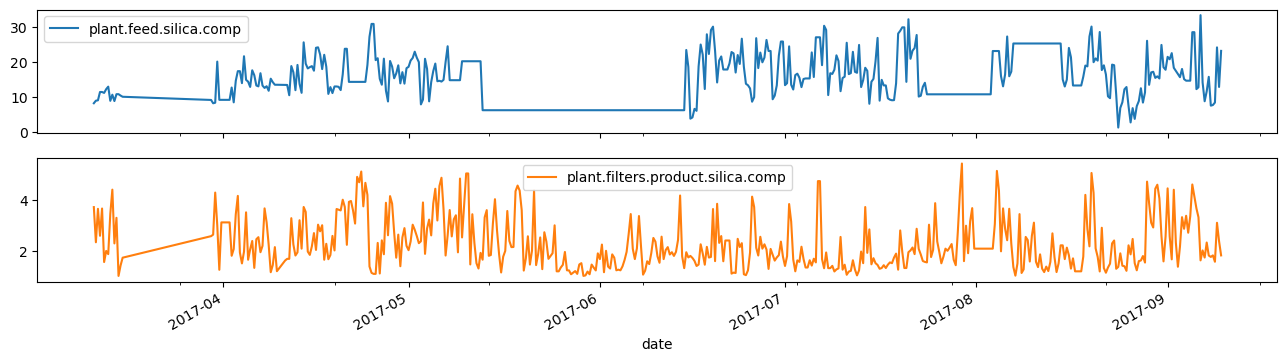

In [5]:
# Plots
tags = ['plant.feed.silica.comp','plant.filters.product.silica.comp']
df[tags].plot(subplots=True,figsize=(16,4))

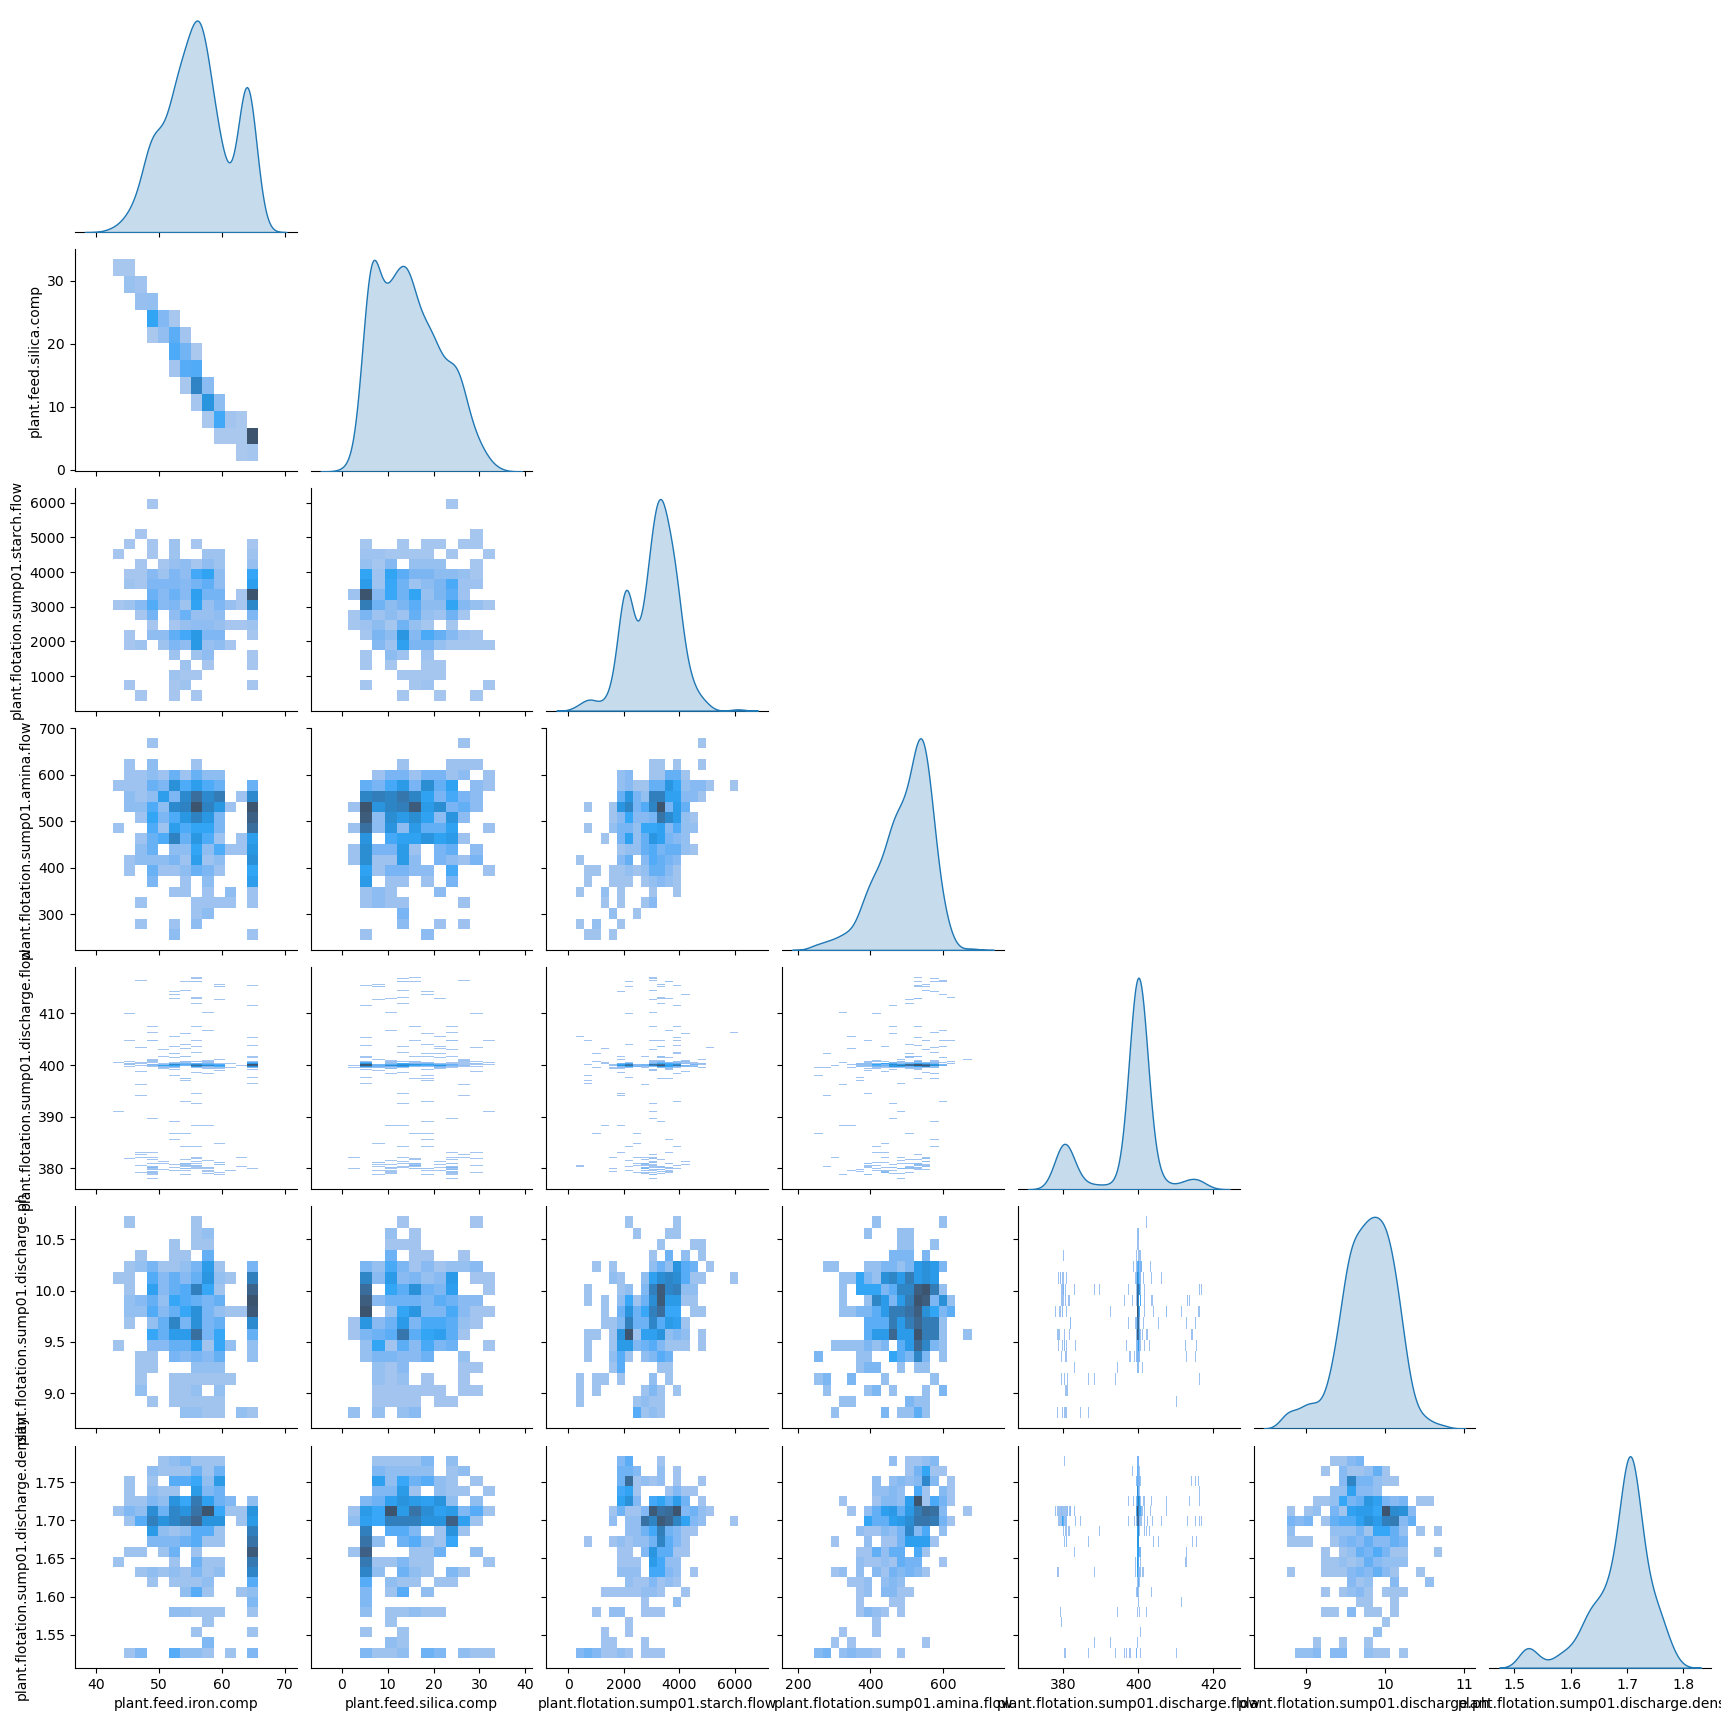

In [6]:
# Feed
feed_variables = [name for name in df.columns if 'feed' in name or 'sump01' in name]
sns.pairplot(data=df,vars=feed_variables,corner=True,kind='hist',diag_kind='kde')

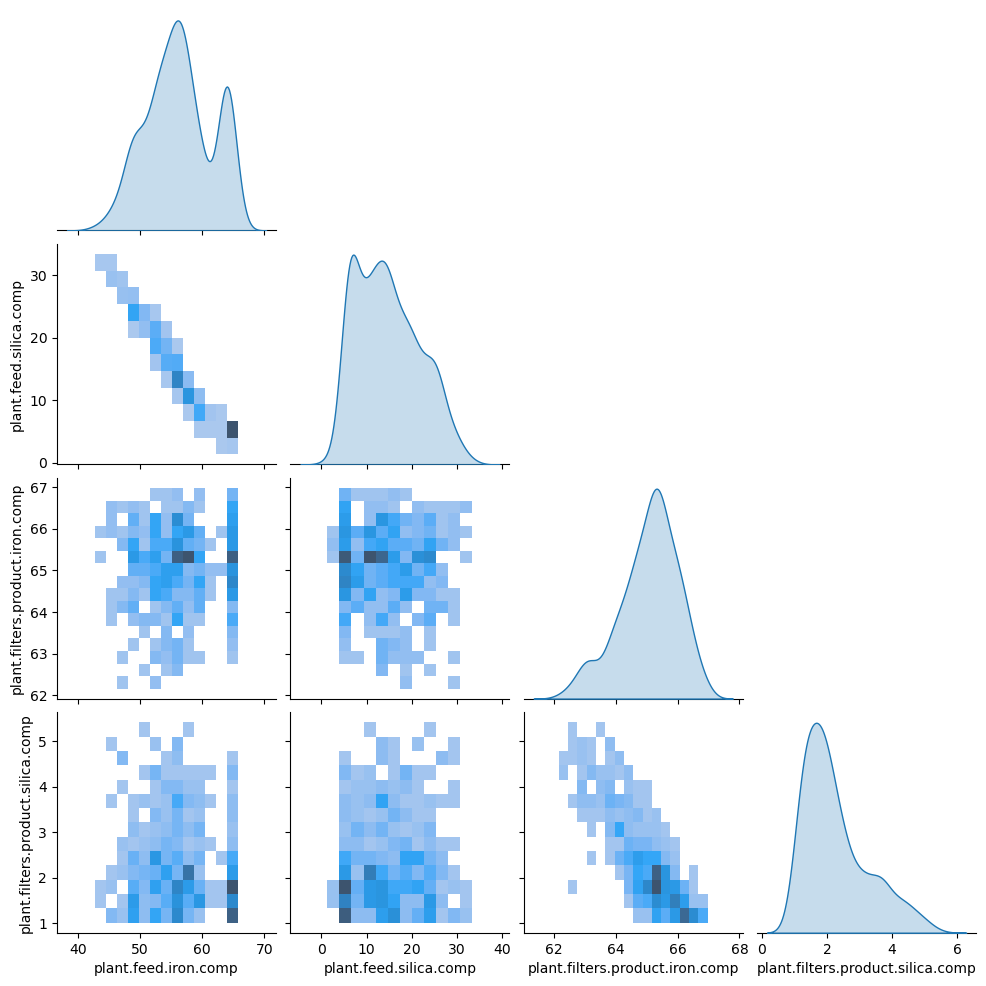

In [7]:
# Feed and product compositions
assay_variables = [name for name in df.columns if 'iron' in name or 'silica' in name]
sns.pairplot(data=df,vars=assay_variables,corner=True,kind='hist',diag_kind='kde')

<Axes: >

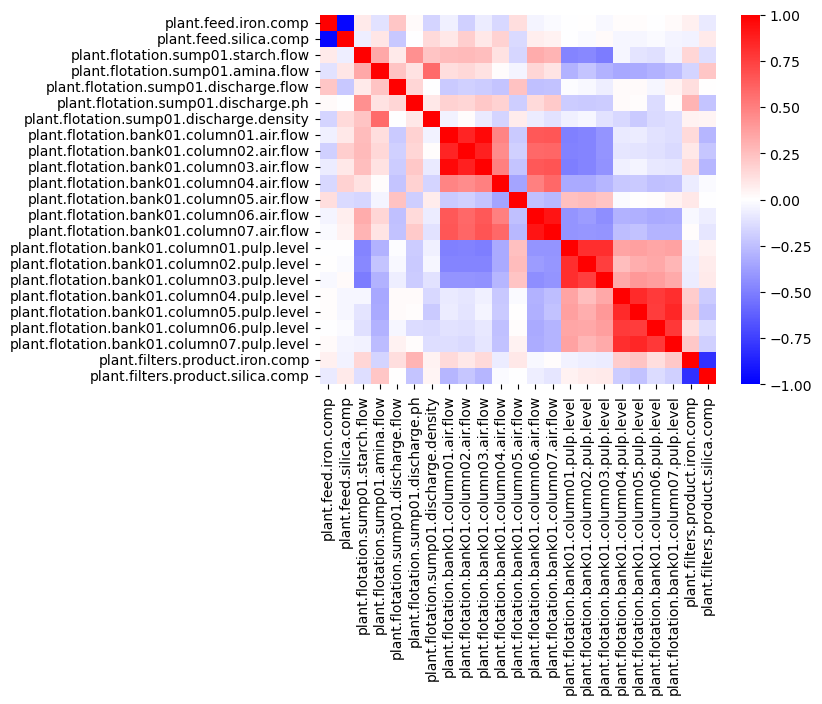

In [8]:
# Correlation matrix
corr = df.corr()
sns.heatmap(corr,cmap='bwr',vmin=-1,vmax=+1)

In [9]:
# Data partitioning
# Input variables
X_names = df.columns
X_names = X_names.drop('plant.filters.product.iron.comp')
X_names = X_names.drop('plant.filters.product.silica.comp')
print(X_names)
# Output variables
Y_name = 'plant.filters.product.silica.comp'
# Data frames
X = df[X_names].copy()
Y = df[Y_name].rolling('24h').median().copy()
# Training (and validation) and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle=True)

Index(['plant.feed.iron.comp', 'plant.feed.silica.comp',
       'plant.flotation.sump01.starch.flow',
       'plant.flotation.sump01.amina.flow',
       'plant.flotation.sump01.discharge.flow',
       'plant.flotation.sump01.discharge.ph',
       'plant.flotation.sump01.discharge.density',
       'plant.flotation.bank01.column01.air.flow',
       'plant.flotation.bank01.column02.air.flow',
       'plant.flotation.bank01.column03.air.flow',
       'plant.flotation.bank01.column04.air.flow',
       'plant.flotation.bank01.column05.air.flow',
       'plant.flotation.bank01.column06.air.flow',
       'plant.flotation.bank01.column07.air.flow',
       'plant.flotation.bank01.column01.pulp.level',
       'plant.flotation.bank01.column02.pulp.level',
       'plant.flotation.bank01.column03.pulp.level',
       'plant.flotation.bank01.column04.pulp.level',
       'plant.flotation.bank01.column05.pulp.level',
       'plant.flotation.bank01.column06.pulp.level',
       'plant.flotation.bank01.col

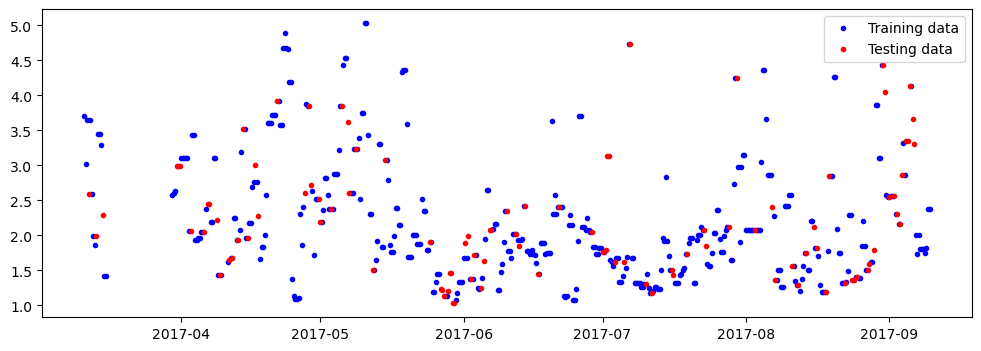

In [10]:
# Understand data partitioning
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(Y_train,'b.',label='Training data')
ax.plot(Y_test,'r.',label='Testing data')
ax.legend()

In [11]:
# Preprocessing: Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [12]:
# Linear model
linear_model = LinearRegression()

In [13]:
# Tree model
tree_model = DecisionTreeRegressor(min_samples_leaf=50)

In [14]:
# Boosted ensemble
boost_model = GradientBoostingRegressor(n_estimators=50)

In [15]:
# Cross-validation
linear_model_cv = cross_val_score(linear_model,X_train_scaled,Y_train,scoring='r2',cv=5)
tree_model_cv = cross_val_score(tree_model,X_train_scaled,Y_train,scoring='r2',cv=5)
boost_model_cv = cross_val_score(boost_model,X_train_scaled,Y_train,scoring='r2',cv=5)

In [16]:
# Model selection
print(f'Linear model average R squared: {linear_model_cv.mean():0.2f}')
print(f'Tree model average R squared: {tree_model_cv.mean():0.2f}')
print(f'Boost model average R squared: {boost_model_cv.mean():0.2f}')

Linear model average R squared: 0.28
Tree model average R squared: 0.17
Boost model average R squared: 0.31


In [17]:
# Fit best model on training and validation data
boost_model.fit(X_train_scaled,Y_train)

GradientBoostingRegressor(n_estimators=50)

In [18]:
# Model performance on test data
X_test_scaled = scaler.transform(X_test)
Y_test_pred = boost_model.predict(X_test_scaled)
r2_test = r2_score(y_true=Y_test,y_pred=Y_test_pred)
print(f'Boost model test R squared: {r2_test:0.2f}')

Boost model test R squared: 0.36


In [19]:
# Model performance on all data
df['predicted.plant.filters.product.silica.comp'] = boost_model.predict(scaler.transform(df[X_names]))
df['Train/test data'] = 'Train'
df.loc[X_test.index,'Train/test data'] = 'Test'
print(f'Boost model average R squared: {r2_score(df['plant.filters.product.silica.comp'],df['predicted.plant.filters.product.silica.comp']):0.2f}')

Boost model average R squared: 0.43


Text(0, 0.5, 'Output variable')

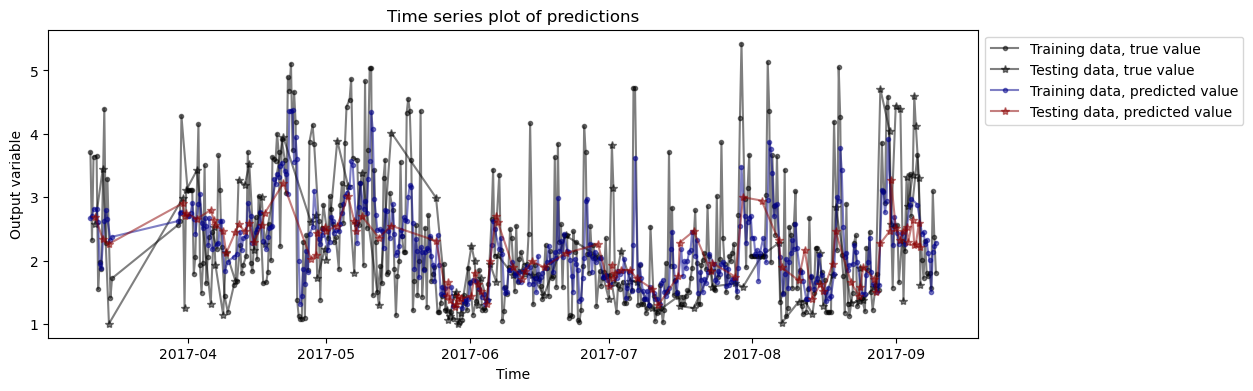

In [20]:
# Time series plot of predictions
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df.loc[df['Train/test data']=='Train','plant.filters.product.silica.comp'],'k.-',label='Training data, true value',alpha=0.5)
ax.plot(df.loc[df['Train/test data']=='Test','plant.filters.product.silica.comp'],'k*-',label='Testing data, true value',alpha=0.5)
ax.plot(df.loc[df['Train/test data']=='Train','predicted.plant.filters.product.silica.comp'],'.-',color='darkblue',label='Training data, predicted value',alpha=0.5)
ax.plot(df.loc[df['Train/test data']=='Test','predicted.plant.filters.product.silica.comp'],'*-',color='darkred',label='Testing data, predicted value',alpha=0.5)
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_title('Time series plot of predictions')
ax.set_xlabel('Time')
ax.set_ylabel('Output variable')

Text(0, 0.5, 'Predicted values')

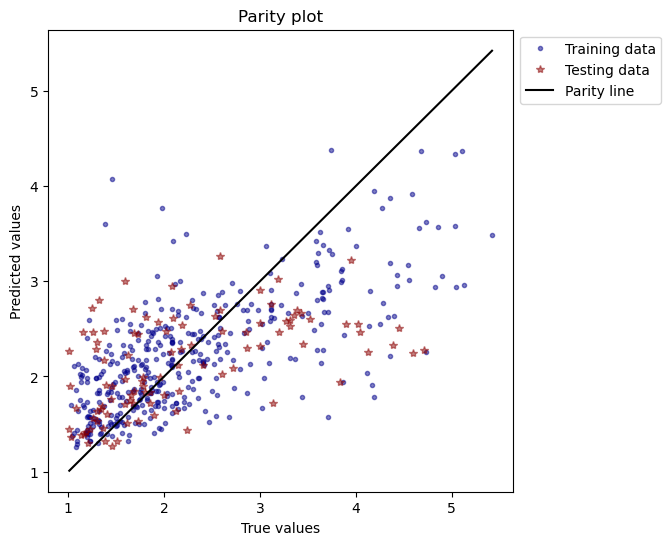

In [21]:
# Parity plot
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(df.loc[df['Train/test data']=='Train','plant.filters.product.silica.comp'],
        df.loc[df['Train/test data']=='Train','predicted.plant.filters.product.silica.comp'],
        '.',color='darkblue',label='Training data',alpha=0.5)
ax.plot(df.loc[df['Train/test data']=='Test','plant.filters.product.silica.comp'],
        df.loc[df['Train/test data']=='Test','predicted.plant.filters.product.silica.comp'],
        '*',color='darkred',label='Testing data',alpha=0.5)
min_y = df['plant.filters.product.silica.comp'].min()
max_y = df['plant.filters.product.silica.comp'].max()
ax.plot([min_y, max_y],[min_y, max_y],color='k',label='Parity line')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_title('Parity plot')
ax.set_xlabel('True values')
ax.set_ylabel('Predicted values')